<a href="https://colab.research.google.com/github/Teoroo-CMC/DoE_Course_Material/blob/main/Week_2/Lab_1/Task_2/opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab: find optimum

In [6]:
#Import all packages
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from numpy.random import rand
import itertools
from matplotlib.pyplot import *
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf


## Experiment
This part defines you experiment. To get data from your experimental setup, just 

```python 
gaussian_function=(x, y, fwhm)
```

which will give you you result 

In [7]:
# Data generation. Doo not touch... This is your physical space :) 

def gaussian_function(x, y, pars=None, add_noise=False):
    # to be changed: genereate all data here
    np.random.seed(2)
    if not pars:
        x0 = np.random.randn(1)[0]+0.5
        y0 = x0+0.5
        fwhm = np.random.normal(loc=1.5,scale=3, size=100).mean()
    else:
        x0, y0, fwhm = pars
        
    func = 10*np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    
    if add_noise:
        func = add_noise_func(func)
    
    return func, x0, y0, fwhm

def add_noise_func(input_data, mean_noise=0):
    # incomplete: refactor code to generate data + noise in one function
    avg_data = np.mean(input_data)
    noise_ = np.random.normal(mean_noise, np.sqrt(avg_data), 1)[0]
    output_data = input_data + noise_
    
    return output_data



This is how you call for experimental data at x=1 and y=1: 

In [8]:
gaussian_function(1,1)[0]

1.5879227876724087

Use DoE and factioral design to locate the maxima. 

To start the experiment, a 2x2 2^2 DoE between -2 and +2 will be done.

In [9]:
# create dictionary for parameters, start parameters from -2 to 2, with centerpoint
input_labels = {'A' : 'x1',
                 'B' : 'x2'}

#Where x1 and x2 are the 2 imput variables for the fuction

#create list of data for high and low. 
data = [('A',0,0.25,0.5),
        ('B',0,0.25,0.5)]

# create pandas dataframe in a pandas dataframe
inputs_df = pd.DataFrame(data,columns=['index', 'low','center', 'high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : input_labels[z] )

#print dataframe hig and low
inputs_df

,low,center,high,label
index,,,,
A,0,0.25,0.5,x1
B,0,0.25,0.5,x2


In [10]:
# compute averages and span
inputs_df['average'] = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2, axis=1)
inputs_df['span'] = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2, axis=1)

# encode the data
inputs_df['encoded_low'] = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_center'] = inputs_df.apply( lambda z : ( z['center'] - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)

inputs_df = inputs_df.drop(['average','span'],axis=1)

inputs_df

,low,center,high,label,encoded_low,encoded_center,encoded_high
index,,,,,,,
A,0,0.25,0.5,x1,-1.0,0.0,1.0
B,0,0.25,0.5,x2,-1.0,0.0,1.0


In [11]:
#Create the design matrix

encoded_inputs= list(itertools.product([-1,1],[-1,1]))
encoded_inputs.append((0,0))

#for i in range(0,5):
#    encoded_inputs.append((0,0))
#encoded_inputs

results=pd.DataFrame(encoded_inputs)
#results=results[results.columns[::-1]]
results.columns=['A','B']

results

,A,B
0,-1,-1
1,-1,1
2,1,-1
3,1,1
4,0,0


In [12]:
#Calculate the experiment matrix 

real_experiment = results

var_labels = []
for var in ['A','B']:
    var_label = inputs_df.loc[var]['label']
    var_labels.append(var_label)
    real_experiment[var_label] = results.apply(
        lambda z : inputs_df.loc[var]['low'] if z[var]<0 else (inputs_df.loc[var]['high'] if z[var]>0 else inputs_df.loc[var]['center']), 
        axis=1)

print("The values of each real variable in the experiment are:")
real_experiment[var_labels]

The values of each real variable in the experiment are:


,x1,x2
0,0.00,0.00
1,0.00,0.50
2,0.50,0.00
3,0.50,0.50
4,0.25,0.25


In [13]:
#Use the function to obtain experimental values, loop over x1 and x2

y=[]

for i in range(0,len(real_experiment)): 
    y.append(gaussian_function(real_experiment['x1'][i], real_experiment['x2'][i])[0])
    
results['Response'] = y

results


,A,B,x1,x2,Response
0,-1,-1,0.00,0.00,5.326879
1,-1,1,0.00,0.50,9.751671
2,1,-1,0.50,0.00,3.936062
3,1,1,0.50,0.50,7.205567
4,0,0,0.25,0.25,7.772751


In [14]:
#Compute main and twoway effects. 

#Main effects
labels = ['A','B']

main_effects = {}

for key in labels:
        average_effects = results.groupby(key)['Response'].mean()
        main_effects[key] = sum( [i*average_effects[i] for i in [-1,1]])


#Two-way effects
twoway_labels = list(itertools.combinations(labels, 2))


twoway_effects = {}
for key in twoway_labels:
    
    effects = results.groupby([key[0],key[1]])['Response'].mean()
    
    twoway_effects[key] = sum([ i*j*effects[i][j]/2 for i in [-1,1] for j in [-1,1] ])
twoway_effects

#Display the effects in a pd df
effects=[] #pd.DataFrame({})
indexes=[]
for i,k in enumerate(main_effects.keys()):
    effects.append(abs(main_effects[k]))
    indexes.append(k)
for i,k in enumerate(twoway_effects.keys()):
    effects.append(abs(twoway_effects[k]))
    indexes.append(k) 
    
effects_df=pd.DataFrame({"Standardized effect":effects})

# reset the indexes
effects_df.index=indexes
# Sort values in descending order
effects_df = effects_df.sort_values(by='Standardized effect', ascending=False)
# Add cumulative percentage column, shows the relative impotance of the parameters
effects_df["cum_percentage"] = round(effects_df["Standardized effect"].cumsum()/effects_df["Standardized effect"].sum()*100,2)

# Display data frame with effects
effects_df

,Standardized effect,cum_percentage
B,3.847148,60.18
A,1.968460,90.96
"(A, B)",0.577643,100.00


From this B (60%) is seen to be more imporatnt than A (30%) and A-B (10%). A-B is thus excluded. 

In [15]:
s = "y_hat = "

s += "%0.8f "%(results['Response'].mean())

for i,k in enumerate(main_effects.keys()):
    if(main_effects[k]<0):
        s += "%0.8f %s "%(main_effects[k]/2.0, k )
    else:
        s += "+ %0.8f %s "%(main_effects[k]/2.0, k )

for i,k in enumerate(twoway_effects.keys()):
    if(twoway_effects[k]<0):
        s += " %0.8f %s %s"%( twoway_effects[k]/2.0, k[0],k[1])
    else:
        s += "+ %0.8f %s %s"%( twoway_effects[k]/2.0, k[0],k[1])



print(s)

y_hat = 6.79858603 -0.98423010 A + 1.92357394 B  -0.28882173 A B


In [26]:
#Automated OLS, gives the same information. 

y1 = results['Response']
xlabs=['A','B']
#x = results[xlabs]
#x = sm.add_constant(x)

res1 = smf.ols(formula='Response ~ A + B', data=results).fit()   #ordinary least square

res1.summary()


/home/aleul811/.local/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Response   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     12.29
Date:                Sun, 18 Jun 2023   Prob (F-statistic):             0.0753
Time:                        21:16:07   Log-Likelihood:                -4.1177
No. Observations:                   5   AIC:                             14.24
Df Residuals:                       2   BIC:                             13.06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7986      0.390     17.438      0.003       5.121       8.476
A             -0.9842      0.436     -2.258      0.152      -2.860       0.891
B              1.9236      0.436      4.413      0.048       0.048       3.799
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.932
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.563
Skew:                           0.743   Prob(JB):                        0.754
Kurtosis:                       2.297   Cond. No.                         1.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The function obtained both from the manual way and the library function that fits the data is: 

y_hat = 6.79858603 -0.98423010 A + 1.92357394 B  -0.28882173 A B

Now the task is to find the maxima of this function. From the calculation of the standardised 
effect, the AB term can be neglected to make a more simple model. 

Lets assume we move 0.1 in A. This giveas moving -0.1954 in B. 


In [ ]:
A = 0.1
B = (A * 1.92357)/(-0.98423)
print(B)


In [32]:
# Calculate x1 and x2, run the function over these values 

Origin = [0,0] 
delta= [A,-B]
march=[(0,0)]

#Create a list on x1 and x2 values to run the experiment on 
for i in range(0,5):
    march.append((Origin[0]+(i+1)*delta[0],Origin[1]+(i+1)*delta[1])) 

March=pd.DataFrame(march, columns=['x1', 'x2'])

March['New_experiments'] = March.apply( lambda row : gaussian_function(row[0], row[1])[0], axis = 1)

#Calculating the straight line
#March['New_responses'] = March.apply(lambda row : 6.7986 - (0.9842*row[0]) + (1.9236*row[1]), axis=1)


March



,x1,x2,New_experiments
0,0.0,0.000000,5.326879
1,0.1,0.195439,7.607909
2,0.2,0.390878,9.122143
3,0.3,0.586317,9.182641
4,0.4,0.781756,7.760281
5,0.5,0.977195,5.505876


Text(0, 0.5, 'Response')

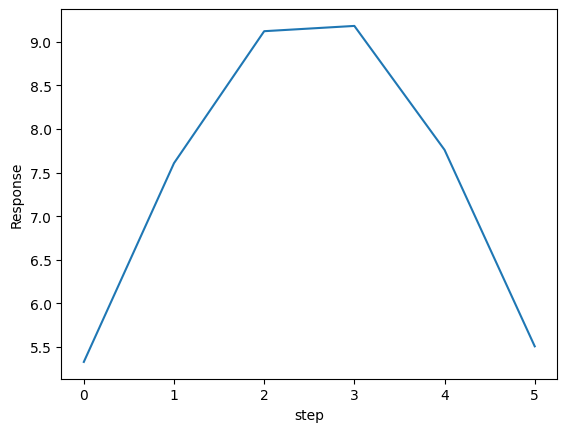

In [33]:
ax=March['New_experiments'].plot()
ax.set_xlabel("step")
ax.set_ylabel("Response")

In [36]:
Max = max(March['New_experiments'])

print(Max) 

9.182640524615206


The maximum of the function can with one iteration of steepest acent be approximated in the point (0.3, 0.58631) to be 9.1826

In [ ]:
#TODO

#Gör en funktion från dessa
#Gör experiment enligt den linjära anpassningen för att se var experimenten avviker --> ger ett approximativt maxima
#Gör ett nytt DoE kring ett approximativt maxima 
#Gör en polynom anpassning för att hitta maximat i den nya DoE rutan 